In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import random
from google.colab.patches import cv2_imshow
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [ ]:
# define hyper params
class hyperParam:
  stride_conv = 1
  stride_conv_final = 1
  stride_conv_hidden = 1
  conv1_infeat = 100
  conv1_outfeat = 100
  conv_hidden_infeat = 100
  conv_hidden_outfeat = 100
  conv_final_infeat = 100
  conv_final_outfeat = 100
  input_size = 100
  n_hidden = 1
  kernel1_size = 3
  kernel2_size = 3
  kernel_size_final = 1

  lr = 0.05
  num_epochs = 50
  batch_size = 50
  momemtum = 0.9
  decay_factor = 0.9
  n_epochs = 1000
  cle_weight = 1
  discontinuity_weight = 0.5
  min_labels = 3

In [ ]:
class CNN(nn.Module):
  def __init__(self,input_dim):
    super(CNN, self).__init__()

    # network architecture
    # conv -> maxpool -> relu ->conv -> maxpool -> relu ->fc -> relu -> fc -> softmax
    
    self.infeat = input_dim
    self.stride_conv1 = hyperParam.stride_conv
    self.stride_conv_hidden = hyperParam.stride_conv_hidden
    self.stride_conv_final = hyperParam.stride_conv_final

    # non zero padding, unit stride 
    # used this calculations to make output features dynamic. 
    # for now, just replicated the original parameters of the model with adaptive learning rate schedule
    # self.opfeats_conv1 = np.floor((self.infeat - hyperParam.kernel1_size)/self.stride_conv1) +1


    # self.opfeats_conv2 = np.floor((self.opfeats_maxpool1 - hyperParam.kernel2_size)/self.stride_conv2) +1

    
    self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=hyperParam.conv1_outfeat, kernel_size=hyperParam.kernel1_size, stride = (self.stride_conv1,self.stride_conv1), padding=1)
    
    self.convhidden_list = nn.ModuleList()
    self.bnhidden_list = nn.ModuleList()
    

     # batch normalisation
    self.batchnorm1 = nn.BatchNorm2d(hyperParam.conv_final_outfeat)
    self.batchnormhidden = nn.BatchNorm2d(hyperParam.conv_hidden_outfeat)
    self.batchnormfinal = nn.BatchNorm2d(hyperParam.conv_final_outfeat)


    for _ in range(hyperParam.n_hidden):
      self.convhidden_list.append(nn.Conv2d(hyperParam.conv_hidden_infeat, hyperParam.conv_hidden_outfeat, kernel_size=hyperParam.kernel2_size, stride = (self.stride_conv_hidden,self.stride_conv_hidden), padding=1) )
      self.bnhidden_list.append(self.batchnormhidden)
    
    self.conv_final = nn.Conv2d(in_channels=hyperParam.conv_final_infeat, out_channels=hyperParam.conv_final_outfeat, kernel_size=hyperParam.kernel_size_final, stride = (self.stride_conv_final,self.stride_conv_final))



    # layer initialisation
    # xavier layer initialisation (we will experiment with HE initialisation) 
    torch.nn.init.xavier_uniform_(self.conv1.weight) 
    self.conv1.bias.data.fill_(0.0)
    
    for i in range(hyperParam.n_hidden):
      torch.nn.init.xavier_uniform_(self.convhidden_list[i].weight) 
      self.convhidden_list[i].bias.data.fill_(0.0)

    torch.nn.init.xavier_uniform_(self.conv_final.weight) 
    self.conv_final.bias.data.fill_(0.0)

  def forward(self, x):
    x = self.conv1(x)

    x = F.relu(x)
    x = self.batchnorm1(x)

    for i in range(hyperParam.n_hidden):
      x = self.convhidden_list[i](x)

      x = F.relu(x)
      x = self.bnhidden_list[i](x)

    x = self.conv_final(x)
    x = self.batchnormfinal(x)

    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
img = cv2.imread('/content/22090.jpg')
imarr = np.array([img.transpose((2, 0, 1)).astype('float32')/255.])


In [ ]:
data = torch.from_numpy( np.array([img.transpose( (2, 0, 1) ).astype('float32')/255.]) )
data = Variable(data) # for gradient flow
data = data.to(device)


In [ ]:
data.is_cuda

True

In [ ]:
model = CNN(data.size(1))
model.to(device)
model.train()


CNN(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convhidden_list): ModuleList(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bnhidden_list): ModuleList(
    (0): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (batchnorm1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormhidden): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormfinal): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_final): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:

# define loss function, optimiser and lr scheduler
optimizer = torch.optim.SGD(model.parameters(), lr = hyperParam.lr, momentum=hyperParam.momemtum)
scheduler = StepLR(optimizer, 10, hyperParam.decay_factor)
loss_func = nn.CrossEntropyLoss()

# continuity loss function (adapted from the paper)
continitity_lossy = torch.nn.L1Loss(size_average = True)
continitity_lossz = torch.nn.L1Loss(size_average = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
continitity_lossy_target = torch.zeros(img.shape[0]-1, img.shape[1], hyperParam.conv_final_outfeat)
continitity_lossz_target = torch.zeros(img.shape[0], img.shape[1]-1, hyperParam.conv_final_outfeat)

In [ ]:
# move targets of continutiy loss onto device
continitity_lossy_target = continitity_lossy_target.to(device)
continitity_lossz_target = continitity_lossz_target.to(device)

In [ ]:
data.is_cuda


True

In [ ]:
label_colours = np.random.randint(255,size=(100,3))


In [ ]:
for batch_idx in range(hyperParam.n_epochs+1):
  optimizer.zero_grad()
  output = model( data )[ 0 ]
  print(f'output.shape: {output.shape}')

  output = output.permute( 1, 2, 0 ).contiguous().view( -1,hyperParam.conv_final_outfeat)
  output_ = output.reshape((img.shape[0], img.shape[1], hyperParam.conv_final_outfeat))


  output_discontinuity_y = output_[1:, :, :] - output_[0:-1, :, :]
  output_discontinuity_z = output_[:, 1:, :] - output_[:, 0:-1, :]
  contloss_y = continitity_lossy(output_discontinuity_y,continitity_lossy_target)
  contloss_z = continitity_lossz(output_discontinuity_z,continitity_lossz_target)
  

  _, target = torch.max( output, 1 )
  im_target = target.data.cpu().numpy()
  n_labels = len(np.unique(im_target))
  img_list = []
  
  
  
  
  im_target_rgb = np.array([label_colours[ c % hyperParam.conv_final_outfeat ] for c in im_target])
  
  # print(f'im_target: {im_target[0]}')
  #for i in range(n_labels):
  im_target_rgb = im_target_rgb.reshape(img.shape).astype( np.uint8 )
  unique_targets = np.unique(im_target)
  plt.imshow(im_target_rgb)
  plt.title('output')
  plt.show()
  
  if batch_idx %100==0 or batch_idx == hyperParam.n_epochs:
    for i in range(n_labels):
      inner_img = np.zeros_like(img)
      img_list.append(inner_img)

    for i in range(n_labels):
      unique_clusters = unique_targets[i]
      for j in range(im_target_rgb.shape[0]):
        for k in range(im_target_rgb.shape[1]):
          for m in range(im_target_rgb.shape[2]):
            if im_target_rgb[j,k,m] == label_colours[ unique_clusters% hyperParam.conv_final_outfeat][m]:
              img_list[i][j,k,m] = im_target_rgb[j,k,m]
  # print(np.unique(im_target))
  # print(im_target_rgb)

  
  if batch_idx %100==0:
      for i in range(n_labels):
        plt.imshow(img_list[i])
        plt.title(f'cluster -> {i}')
        plt.show()


  loss = hyperParam.cle_weight * loss_func(output, target) #+ hyperParam.discontinuity_weight * (contloss_y + contloss_z)
      
  loss.backward()
  optimizer.step()

  print(batch_idx, '/', hyperParam.n_epochs, '|', ' label num :', n_labels, ' | loss :', loss.item(), len(img_list))

  if n_labels <= hyperParam.min_labels:
      print ("nLabels", n_labels, "reached minLabels", hyperParam.min_labels, ".")
      break




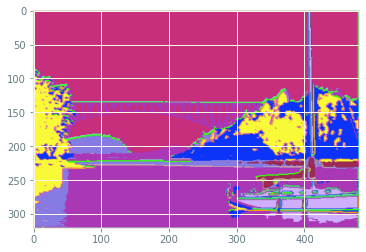

In [ ]:
plt.imshow(im_target_rgb)

In [ ]:
f = open('/content/22090.seg')
lines = f.readlines()
segarrlist = []
n_segments = int(lines[6].rstrip().split('segments')[1])
label_colours = np.random.randint(255,size=(100,3))
seg_img = np.zeros_like(img)
seg_data = lines[11:]
print(n_segments)
for i in range(n_segments):
  segarr = np.zeros_like(img)
  segarrlist.append(segarr)

for i in range(len(seg_data)):
  seg_data[i]=seg_data[i].rstrip()
df_arr=[]
for i in range(len(seg_data)):
  line = seg_data[i].split()
  line = list(map(int, line))
  df_arr.append(line)
  
for i in range(n_segments):
  for arr in df_arr:
    cluster, row, c1, c2 = arr
    #print(f'arr: {arr}')
    seg_img[row, c1:c2, :] = label_colours[cluster]
    segarrlist[cluster][row, c1:c2, :] = label_colours[cluster]

14


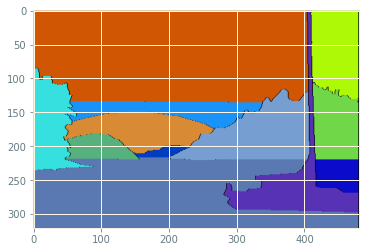

In [ ]:
plt.imshow(seg_img)

In [ ]:
import numpy as np
def get_iou(img_idx, seg_idx, image1, image2):
  intersection = np.logical_and(image1[img_idx],image2[seg_idx])
  union = np.logical_or(image1[img_idx],image2[seg_idx])
  iou_score = np.sum(intersection) / np.sum(union) if np.sum(union)>0 else 0
  return iou_score

iou: 0.0011798355380765106
iou: 0.017908451401961754
iou: 0.001502215768258181
iou: 0.000977366255144033
iou: 0.0006823072482023829
iou: 0.0011661140962615753
iou: 0.0
iou: 0.07614500042381261
iou: 0.006779489514558195
iou: 0.0022534885736572963
iou: 0.023772788815768758
iou: 0.4362904395145126
iou: 0.0
iou: 0.034472431040162926


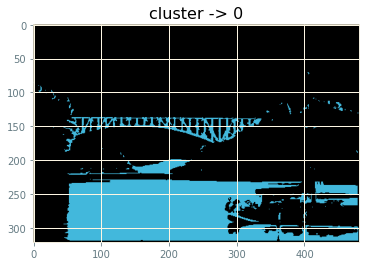

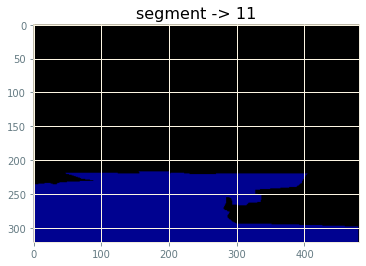

maxiou: 0.4362904395145126
iou: 0.0016597246510444818
iou: 0.007669409910698651
iou: 0.0
iou: 0.006652787834902245
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0011517771243512785
iou: 0.0
iou: 0.0


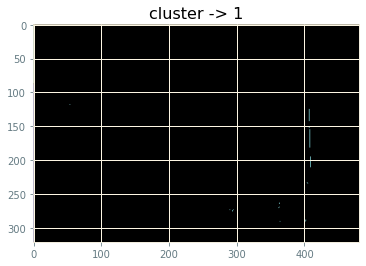

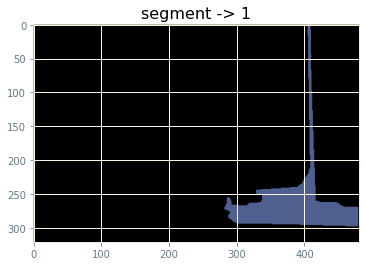

maxiou: 0.007669409910698651
iou: 0.007700833142245662
iou: 0.0
iou: 0.007853100819956115
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0


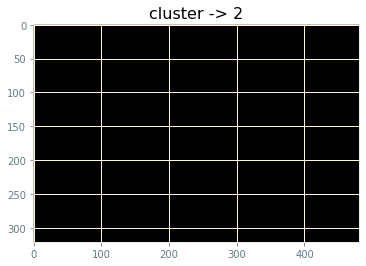

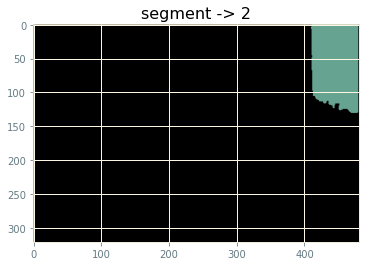

maxiou: 0.007853100819956115
iou: 0.0
iou: 0.006862644678889685
iou: 0.0
iou: 0.00512214342001576
iou: 0.030307576894223556
iou: 0.006834995175297523
iou: 0.0
iou: 0.000880152559777028
iou: 0.0008209217778820218
iou: 0.0017543859649122807
iou: 0.0
iou: 0.000536480686695279
iou: 0.0
iou: 0.0027556644213104714


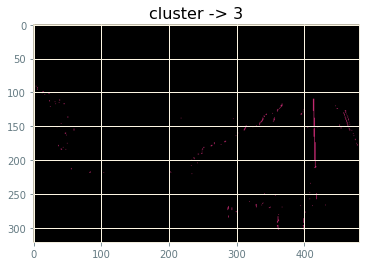

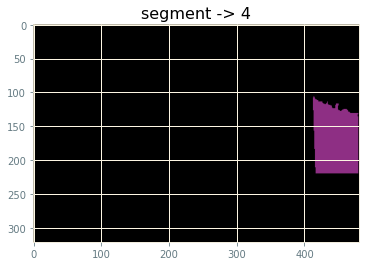

maxiou: 0.030307576894223556
iou: 0.0005539887187751814
iou: 0.008483633934535738
iou: 0.00011148686313129437
iou: 0.023973343718897398
iou: 0.000328669358625223
iou: 0.0007060669456066946
iou: 0.0
iou: 0.0041735831159592125
iou: 0.00038028597505324003
iou: 0.00761537755757409
iou: 0.0
iou: 0.0022626241115872975
iou: 0.0
iou: 0.0022846263683960017


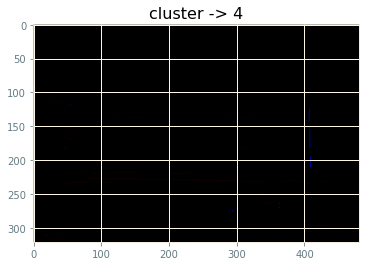

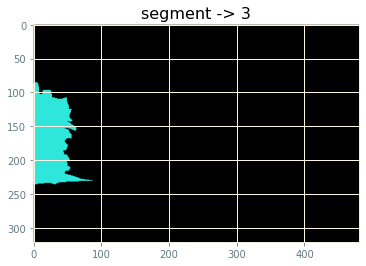

maxiou: 0.023973343718897398
iou: 0.007292716445258818
iou: 0.049247367963107976
iou: 0.0053176858897955445
iou: 0.008985092914028997
iou: 0.0055273048861375195
iou: 0.007169682485489928
iou: 0.0
iou: 0.031214399635452268
iou: 0.01604833380534315
iou: 0.017818574514038878
iou: 0.0017281105990783411
iou: 0.019566771608112685
iou: 0.0
iou: 0.0


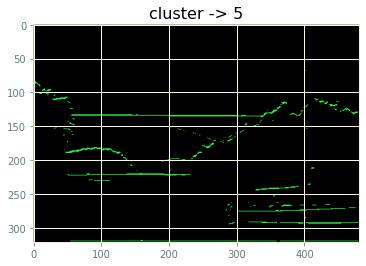

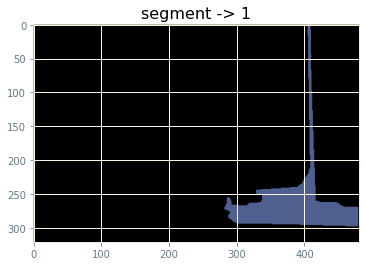

maxiou: 0.049247367963107976
iou: 0.00021737645254050965
iou: 0.046554572844785695
iou: 0.0005516100117217127
iou: 0.017971403744371593
iou: 0.008354506696524697
iou: 0.005703895586330577
iou: 0.0
iou: 0.04483037156704362
iou: 0.002186640332933625
iou: 0.005452730205053376
iou: 0.0
iou: 0.003096857790735342
iou: 0.0
iou: 0.015425403711737768


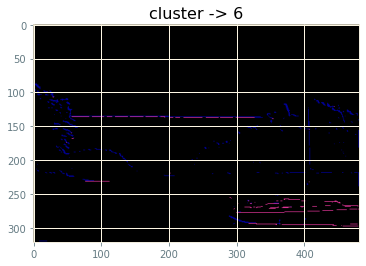

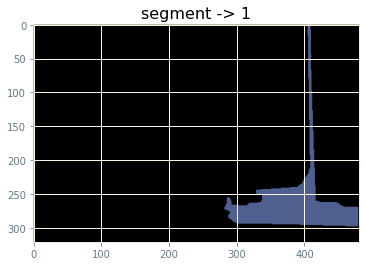

maxiou: 0.046554572844785695
iou: 0.0
iou: 0.03068206115031003
iou: 0.0
iou: 0.0
iou: 0.0
iou: 8.109642364771714e-05
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 2.701570963515284e-05
iou: 0.0
iou: 0.0


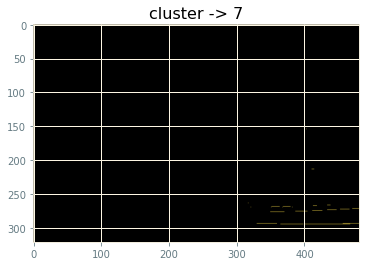

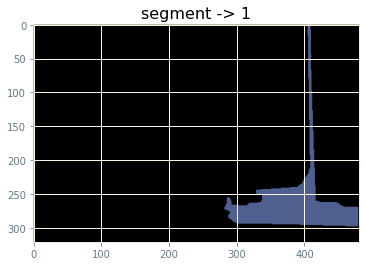

maxiou: 0.03068206115031003
iou: 0.0
iou: 0.020777027027027026
iou: 0.0009662912996617981
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.012882057902026437
iou: 0.0
iou: 0.0


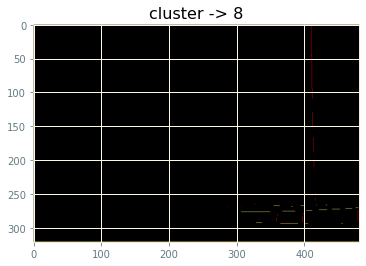

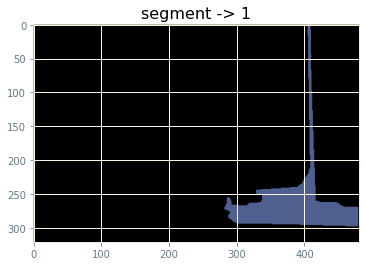

maxiou: 0.020777027027027026
iou: 0.0
iou: 0.0885744363111122
iou: 0.0
iou: 0.08225157627457134
iou: 0.10987708242341049
iou: 0.10144866768695361
iou: 0.0
iou: 0.0
iou: 7.393897569872332e-05
iou: 0.0027398348157560357
iou: 0.0
iou: 0.015060172699045849
iou: 0.0
iou: 0.0010898962580228474


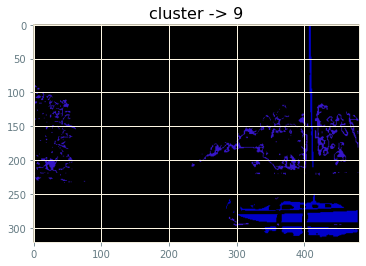

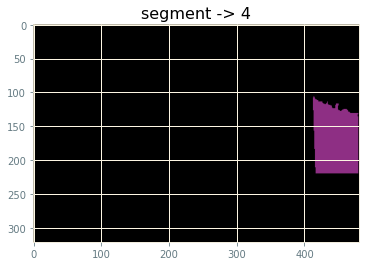

maxiou: 0.10987708242341049
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0011475096308844021
iou: 0.0
iou: 0.0


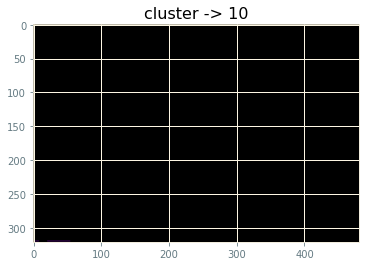

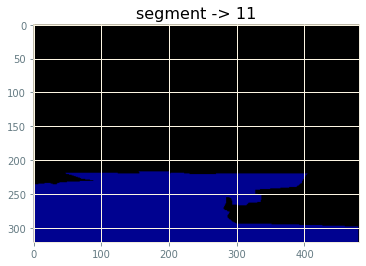

maxiou: 0.0011475096308844021
iou: 0.0
iou: 0.06785515320334262
iou: 0.0
iou: 0.0016506514177916643
iou: 0.0009264978381717109
iou: 0.009187442289935364
iou: 0.0
iou: 0.0
iou: 0.0001119194180190263
iou: 0.19133843569161843
iou: 0.0
iou: 0.11828683522231909
iou: 0.0
iou: 0.07071307300509339


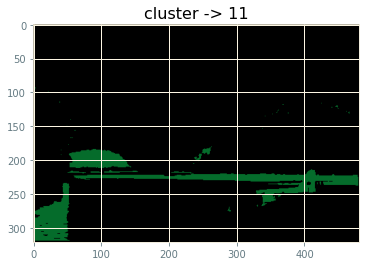

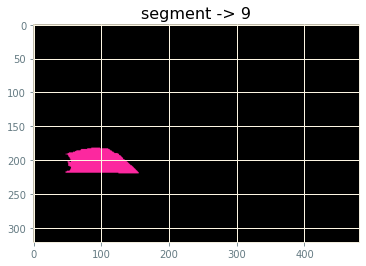

maxiou: 0.19133843569161843
iou: 0.007648364995919607
iou: 0.03329273244011368
iou: 0.00754047460634287
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.00029089755117152376
iou: 0.0
iou: 0.0033213396069748133


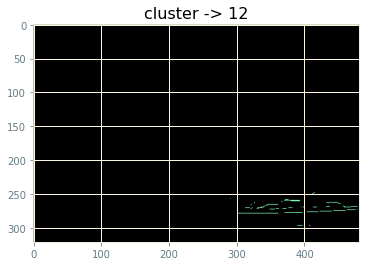

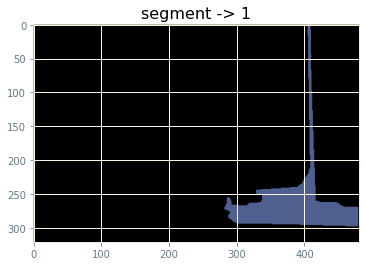

maxiou: 0.03329273244011368
iou: 0.0
iou: 0.01652806652806653
iou: 0.0030026561958655736
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0


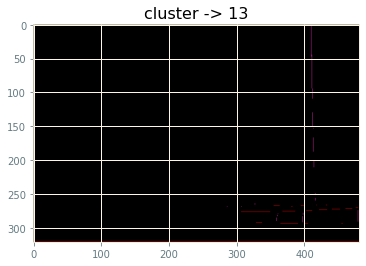

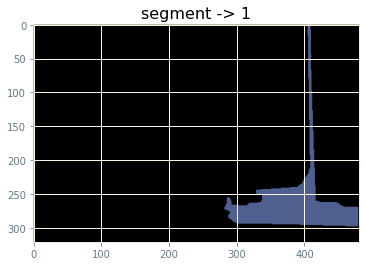

maxiou: 0.01652806652806653
iou: 0.0
iou: 0.29463458460847347
iou: 0.0
iou: 0.024884124394727983
iou: 0.03256768752774079
iou: 0.03068231534496205
iou: 0.0
iou: 0.0
iou: 2.3684335180711476e-05
iou: 0.0008557821104331002
iou: 0.0
iou: 0.027992832752966632
iou: 0.0
iou: 0.0003404319703445928


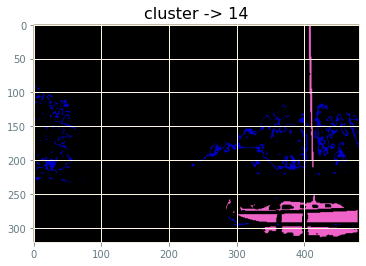

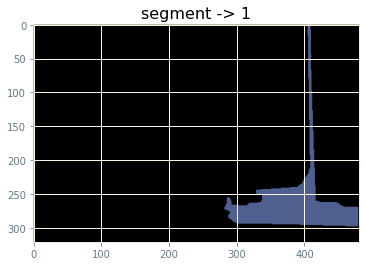

maxiou: 0.29463458460847347
iou: 0.00013174486665537425
iou: 0.01107375914573858
iou: 0.014215904042647711
iou: 0.0006215813028344107
iou: 0.0005510400881664141
iou: 0.002016911023194477
iou: 0.0
iou: 0.03960253456221198
iou: 0.00011199462425803562
iou: 0.0005235602094240838
iou: 0.0
iou: 0.0006865955424104785
iou: 0.001141552511415525
iou: 0.003005464480874317


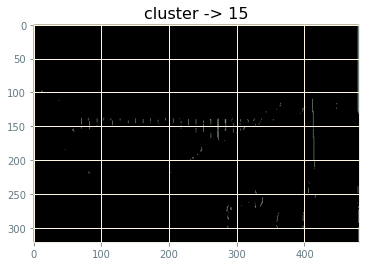

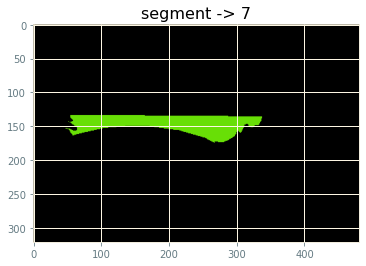

maxiou: 0.03960253456221198
iou: 0.0005468140402184799
iou: 0.02571196583766878
iou: 0.0012992918859221724
iou: 0.05079256210943454
iou: 0.02362300604781426
iou: 0.015968977311045813
iou: 0.0
iou: 0.05010464629552114
iou: 0.005122064790793588
iou: 0.014506572226384254
iou: 0.0
iou: 0.002366160114385494
iou: 0.0
iou: 0.0044509353918909525


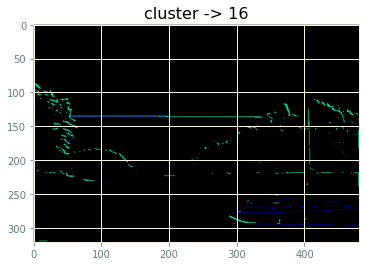

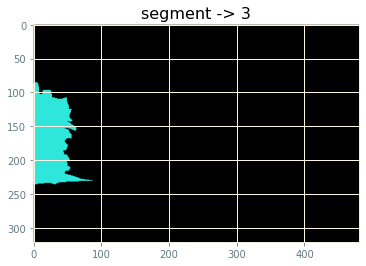

maxiou: 0.05079256210943454
iou: 0.0
iou: 0.003238491788110109
iou: 0.0
iou: 0.32554189033090986
iou: 0.07234091299616244
iou: 0.22314215464900397
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0013105301094292641
iou: 0.0
iou: 0.028973594986129662
iou: 0.0
iou: 0.010958171856207403


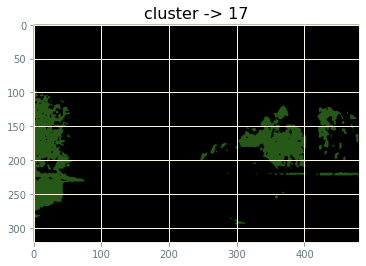

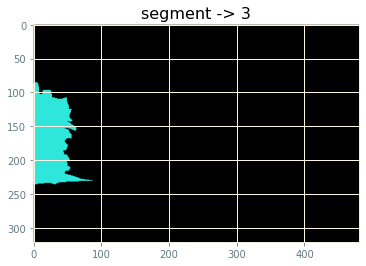

maxiou: 0.32554189033090986
iou: 0.7234251828199171
iou: 5.1293888333205097e-05
iou: 0.11339250807257352
iou: 6.595957996939476e-05
iou: 6.66506705057453e-05
iou: 3.718670203535216e-05
iou: 0.0
iou: 0.032541037787815356
iou: 0.10900624710782045
iou: 0.0
iou: 2.8817198103828364e-05
iou: 0.0
iou: 0.0
iou: 0.0


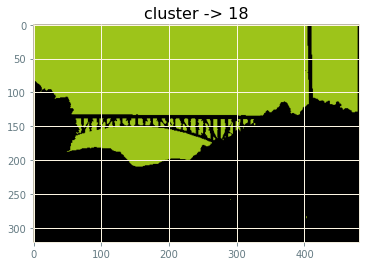

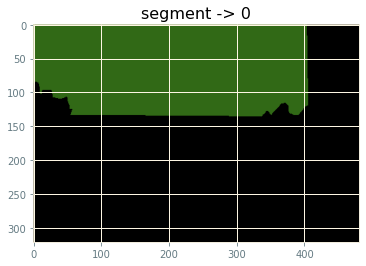

maxiou: 0.7234251828199171
iou: 1.864825048330049e-05
iou: 0.017188439745497136
iou: 0.00031203411572998645
iou: 0.01934944459927539
iou: 0.0009042369962108164
iou: 0.0020186412799681006
iou: 0.0
iou: 0.01155411615387982
iou: 0.0010632265381343919
iou: 0.019648070701491358
iou: 0.0
iou: 0.019050131926121372
iou: 0.0
iou: 0.005807856739533758


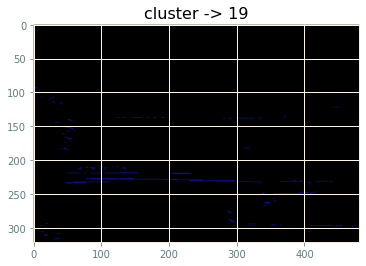

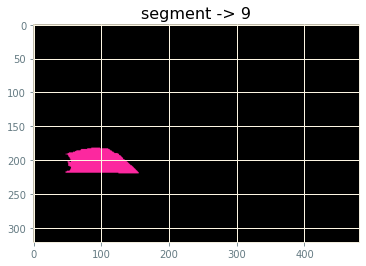

maxiou: 0.019648070701491358
iou: 0.0
iou: 0.03890551517742625
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.00013466199838405601
iou: 0.0
iou: 0.0


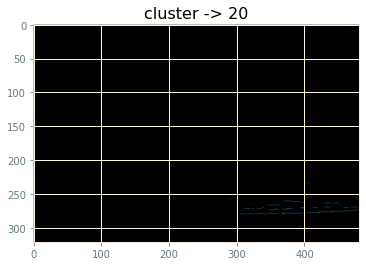

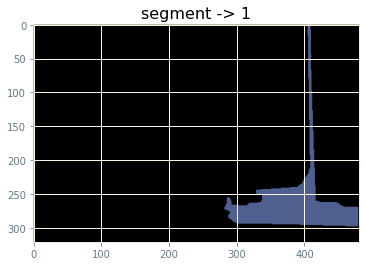

maxiou: 0.03890551517742625
iou: 0.001571404229538613
iou: 0.054699049630411826
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0
iou: 0.0005064235833466602
iou: 0.0
iou: 0.0


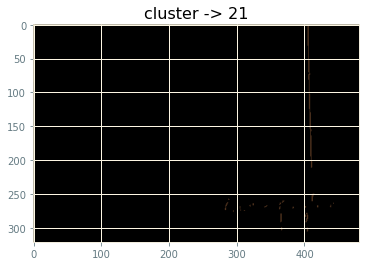

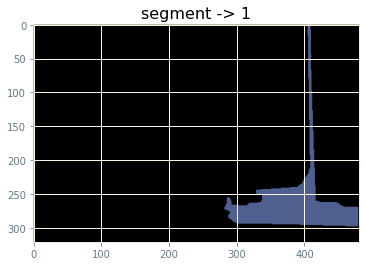

maxiou: 0.054699049630411826
iou: 4.7109812974042495e-05
iou: 0.022900763358778626
iou: 0.0
iou: 0.028260148213693177
iou: 0.240041782729805
iou: 0.28906593406593406
iou: 0.0
iou: 0.005263157894736842
iou: 0.00015407529145909302
iou: 0.037106555010106845
iou: 0.0004924895345973898
iou: 0.007938146264567342
iou: 0.0
iou: 0.037818500401547786


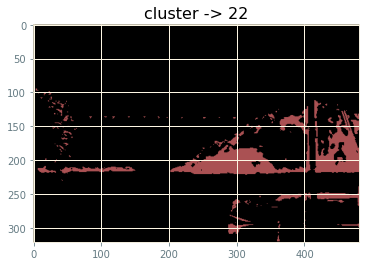

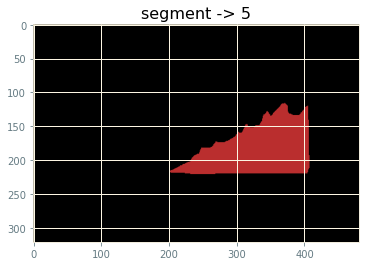

maxiou: 0.28906593406593406
maxiou overall: 0.7234251828199171
mean iou: 0.12355887176364448


In [ ]:
maxiou = 0
maxious = []
for i in range(len(img_list)):
  ious = []
  
  for j in range(len(segarrlist)):
    iou_score = get_iou(i,j, img_list, segarrlist)
    print(f'iou: {iou_score}')
    ious.append(iou_score)
  maxj = np.argmax(ious)
  maxiou_loc = np.max(ious)
  maxious.append(maxiou_loc)
  maxiou = max(maxiou, maxiou_loc)

  plt.figure()
  plt.imshow(img_list[i])
  plt.title(f'cluster -> {i}')
  plt.show()
  plt.figure()
  plt.imshow(segarrlist[maxj])
  plt.title(f'segment -> {maxj}')
  plt.show()
  print(f'maxiou: {np.max(ious)}')

print(f'maxiou overall: {maxiou}')
print(f'mean iou: {np.mean(maxious)}')

  


In [ ]:
cv2.imwrite('cnn_op_22090.jpg',im_target_rgb)

True

# GMM

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

In [ ]:
class GaussianMixtureModel:

  def __init__(self, n_components, means, covars, pi):

    '''
    Initialises gmm parameters

    Parameters:
    -----------
    n_components: int
      Number of components

    means: list()
      List of means
    
    covars: list()
      List of covariances
    
    pi: list()
      List of priors
    
    Returns:
    -------
    None
    '''
    self.n_components = n_components
    self.means = np.asarray(means)
    self.covars = np.asarray(covars)
    self.pi = np.asarray(pi)
    print(f'self.n_components: {self.n_components}')
  def expectation(self, data):
    '''
    Generates beliefs and log likelihoods
    
    Parameters:
    -----------
    data: np.array()
      Array containing image pixel data
    
    Returns:
    -------
    None
    '''
    probs = []
    for i in range(self.n_components):
      mu, covar, prior = self.means[i,:], self.covars[i,:,:], self.pi[i]
      prob = prior* multivariate_normal.pdf(data, mean=mu, cov=covar)
      probs.append(np.expand_dims(prob, -1))
    predictions = np.concatenate(probs, axis=1)
    log_likelihood = np.sum(predictions, axis=1)
    log_likelihood = np.sum(np.log(log_likelihood))

    beliefs = predictions / np.sum(predictions, axis=1, keepdims=True)
    #log_likelihood = np.sum(np.log(log_likelihood))
    return np.asarray(beliefs), log_likelihood


  
  def maximization(self, data, beliefs):
    '''
    Generates new mu, sigma and pi values
    
    Parameters:
    -----------
    data: np.array()
      Array containing image pixel data
    
    beliefs: np.array()
      Array containing posterior probabilities
    
    Returns:
    -------
    None
    '''
    mus_, covars_, pis_ = [],[],[]
    counts = np.sum(beliefs, axis=0)

    for i in range(self.n_components):
      sums = np.sum(np.expand_dims(beliefs[:,i], -1)*data, axis=0)
      mu_ = sums/counts[i]
      mus_.append(mu_)

      data_shifted = np.subtract(data, np.expand_dims(mu_, 0))
      cov_ = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:,i],-1),data_shifted)), data_shifted)
      cov_/=counts[i]
      covars_.append(cov_)
      pis_.append(counts[i]/np.sum(counts))
    
    self.means = np.asarray(mus_)
    self.covars = np.asarray(covars_)
    self.pi = np.asarray(pis_)

  
  


In [ ]:
img = cv2.imread('/content/22090.jpg')

In [ ]:

# getting image pixels data
imarr = np.asarray(img,dtype='int32')
image_data = imarr.reshape(-1, imarr.shape[2])

# finding the initial distribution from kmeans
wcss = []
for i in range(1,40):
  kmeans = KMeans(n_clusters=i,init = 'k-means++', random_state = 42)
  kmeans.fit(image_data)
  #labels = kmeans.fit_predict(image_pixels)
  wcss.append(kmeans.inertia_)


  

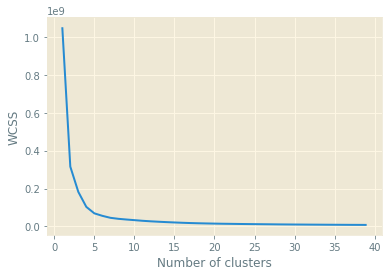

In [ ]:
plt.plot(range(1, 40), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [ ]:
imarr = np.asarray(img, dtype='int32')

In [ ]:
print(imarr.shape)

(321, 481, 3)


In [ ]:
image_data = np.reshape(imarr,(-1, imarr.shape[2]))
_mean = np.mean(image_data,axis=0,keepdims=True)
_std = np.std(image_data,axis=0,keepdims=True)
image_pixels = (image_data - _mean) / _std 

In [ ]:
K=8
kmeans = KMeans(n_clusters=K)
labels = kmeans.fit_predict(image_pixels)

In [ ]:
labels = labels.flatten()

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

[[ 5.07802699e-01  1.31810065e+00  1.75627796e+00]
 [-1.16927730e+00 -1.06417366e+00 -8.64029450e-01]
 [-7.11797618e-01 -5.43401862e-01 -2.50512490e-01]
 [ 1.54425366e+00  2.40061558e+00  3.24815150e+00]
 [ 4.49186332e-02  2.58149588e-02  2.24393747e-03]
 [-1.51231285e+00 -1.52115923e+00 -1.50354761e+00]
 [-2.10779866e+00 -2.08639254e+00 -1.83876203e+00]
 [ 7.33476538e-01  6.01866268e-01  4.21054777e-01]]


In [ ]:
print(labels)

[7 7 7 ... 7 4 4]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


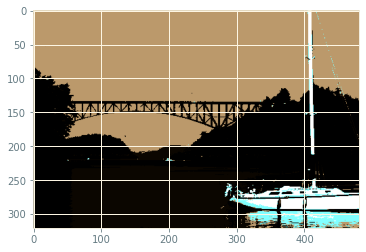

In [ ]:
plt.imshow(centers[labels].reshape(imarr.shape))
plt.show()

In [ ]:


mus = kmeans.cluster_centers_
priors, covs = [],[]

for i in range(K):
  print(i)
  data = np.array([image_pixels[j,:] for j in range(len(labels)) if labels[j]==i]).T
  covs.append(np.cov(data))
  priors.append(data.shape[1]/float(len(labels)))
gmm = GaussianMixtureModel(K, mus, covs, priors)

prev_ll = None
for i in range(3000):
  beliefs, log_likelihood = gmm.expectation(image_pixels)
  gmm.maximization(image_pixels, beliefs)

  if prev_ll !=None and np.abs(log_likelihood - prev_ll) < 1e-10:
    break
  prev_ll = log_likelihood





0
1
2
3
4
5
6
7
self.n_components: 8


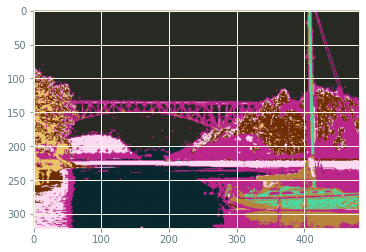

In [ ]:
label_colours = np.random.randint(255,size=(K,3))

image_height, image_width, n_channels = img.shape
beliefs, log_likelihood = gmm.expectation(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, K))
unique_labels = set()
segmented_map = np.zeros((image_height, image_width, 3))
for j in range(image_height):
    for k in range(image_width):
        hard_belief = np.argmax(map_beliefs[j, k, :])
        segmented_map[j,k,:] = np.asarray(label_colours[hard_belief]) / 255.0
        unique_labels.add(hard_belief)
plt.imshow(segmented_map)
plt.show()

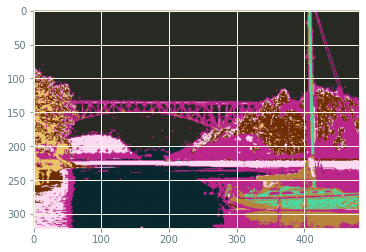

In [ ]:
plt.imshow(segmented_map)
plt.show()

In [ ]:
gauss_img_list = []
for i in range(K):
  gauss_img_list.append(np.zeros_like(segmented_map))
print(unique_labels)
for i in range(K):
  print(gauss_img_list[i].shape)
  for j in range(segmented_map.shape[0]):
      for k in range(segmented_map.shape[1]):
        # hard_belief = np.argmax(map_beliefs[j, k, :])
        # label_color = label_colours[hard_belief]
        for m in range(segmented_map.shape[2]):
                  
          if segmented_map[j,k,m] == label_colours[i][m]/255.0:
            gauss_img_list[i][j,k,m] = segmented_map[j,k,m]

{0, 1, 2, 3, 4, 5, 6, 7}
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)


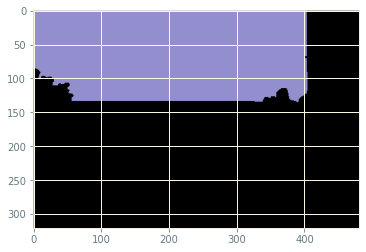

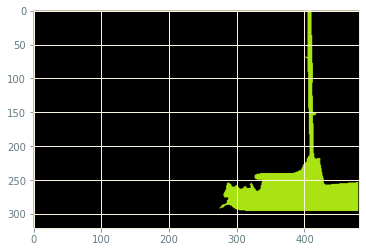

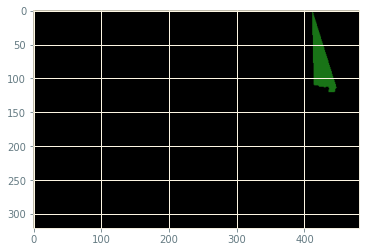

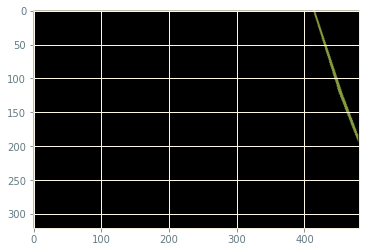

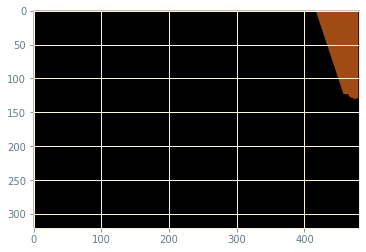

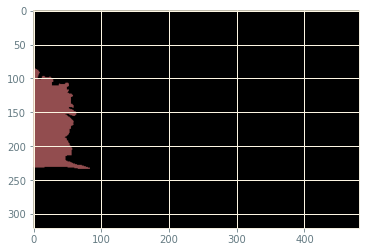

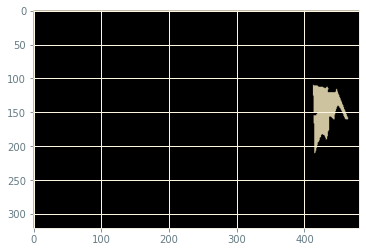

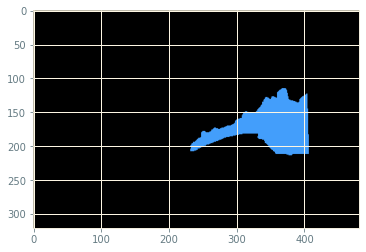

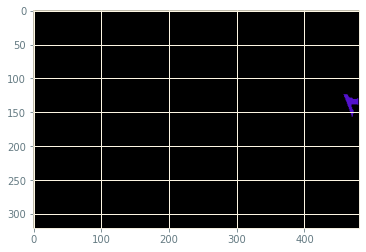

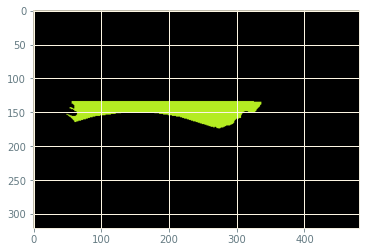

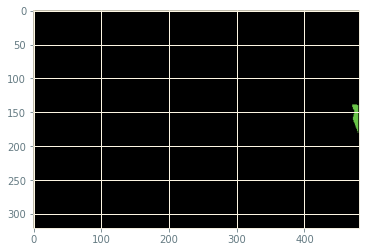

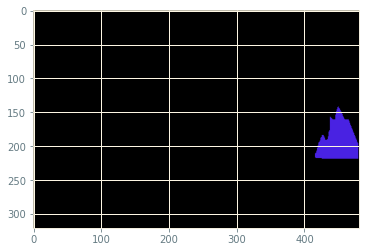

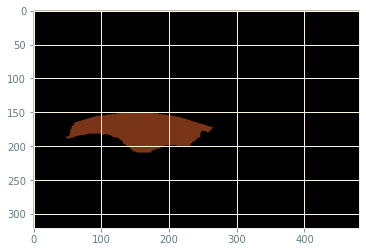

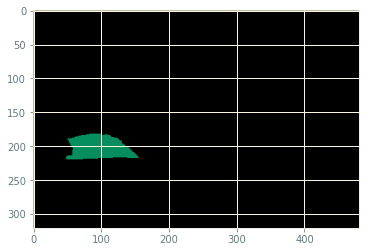

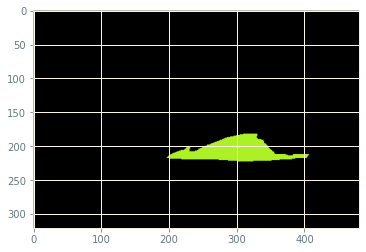

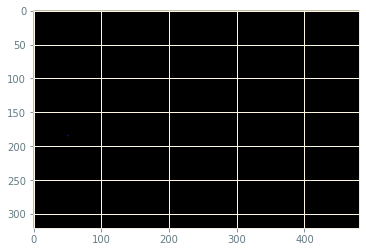

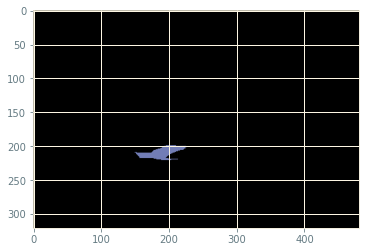

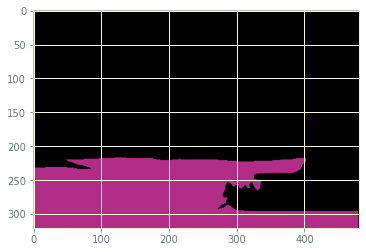

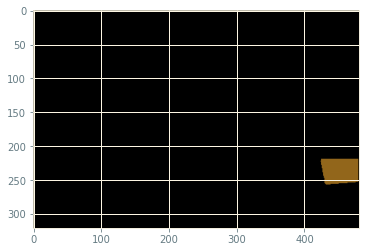

In [ ]:
for i in range(n_segments):
  plt.imshow(segarrlist[i])
  plt.show()

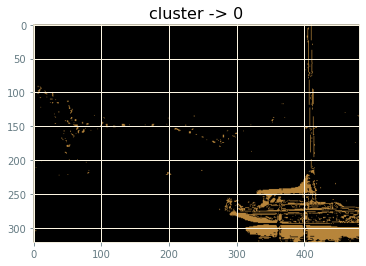

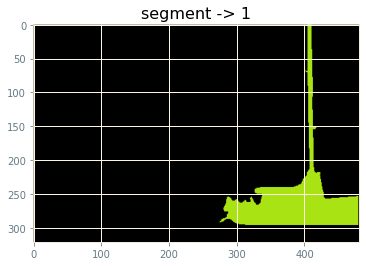

maxiou: 0.2599659284497445


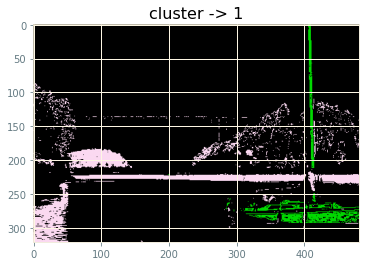

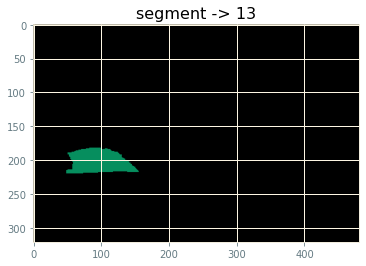

maxiou: 0.13797116114343536


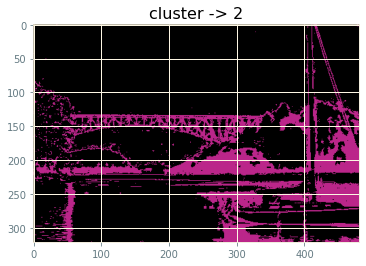

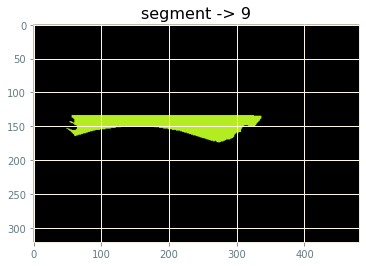

maxiou: 0.1329863205002063


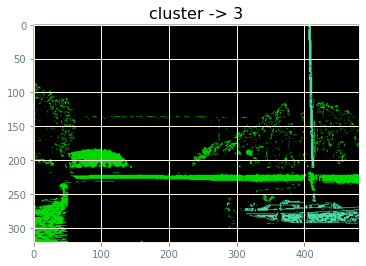

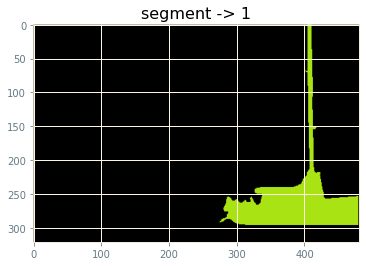

maxiou: 0.22020778162558566


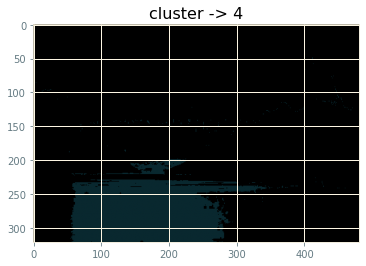

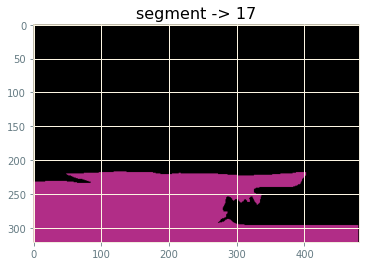

maxiou: 0.5299524308635007


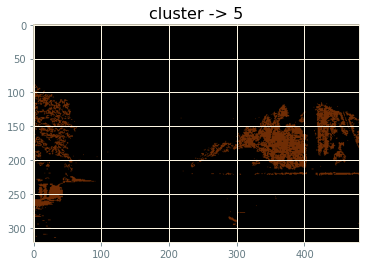

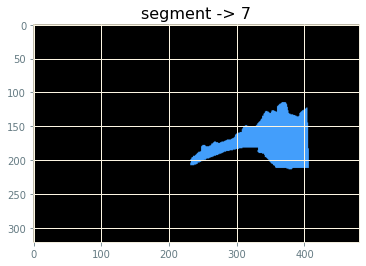

maxiou: 0.34935027845209193


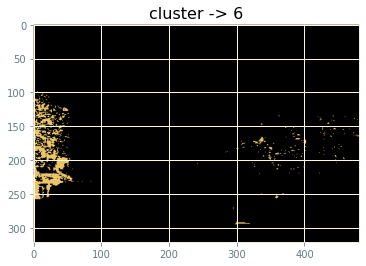

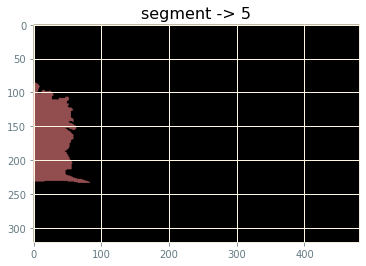

maxiou: 0.3333740980799804


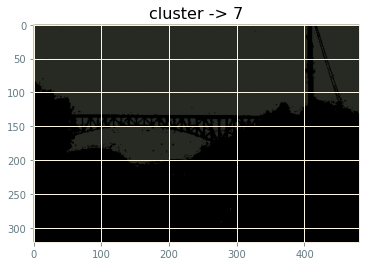

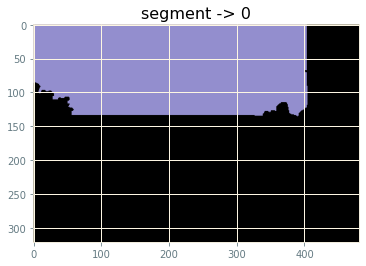

maxiou: 0.7490725519007231
maxiou overall: 0.7490725519007231
mean iou: 0.33911006887690853


In [ ]:
maxiou = 0
maxious = []
for i in range(len(gauss_img_list)):
  ious = []
  
  for j in range(len(segarrlist)):
    iou_score = get_iou(i,j, gauss_img_list, segarrlist)
    ious.append(iou_score)
  maxj = np.argmax(ious)
  maxiou_loc = np.max(ious)
  maxious.append(maxiou_loc)
  maxiou = max(maxiou, maxiou_loc)

  plt.figure()
  plt.imshow(gauss_img_list[i])
  plt.title(f'cluster -> {i}')
  plt.show()
  plt.figure()
  plt.imshow(segarrlist[maxj])
  plt.title(f'segment -> {maxj}')
  plt.show()
  print(f'maxiou: {np.max(ious)}')

print(f'maxiou overall: {maxiou}')
print(f'mean iou: {np.mean(maxious)}')

In [ ]:
cv2.imwrite('gmm_op_22090.jpg',segmented_map*255.0)

True